In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#PanColorization GAN

In [25]:
!git clone https://github.com/ozcelikfu/PanColorGAN.git
!cp PanColorGAN/*.py ./
!gdown --id 1F4iCyeC_5OXWada3UW780YgXx-63GQno --output PanColorGANRD.pth

Downloading...
From: https://drive.google.com/uc?id=1F4iCyeC_5OXWada3UW780YgXx-63GQno
To: /content/PanColorGANRD.pth
32.7MB [00:00, 200MB/s]


In [26]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from networks import define_G
from util import patch_sixteen, divide_sixteen, show_image, scale_range
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

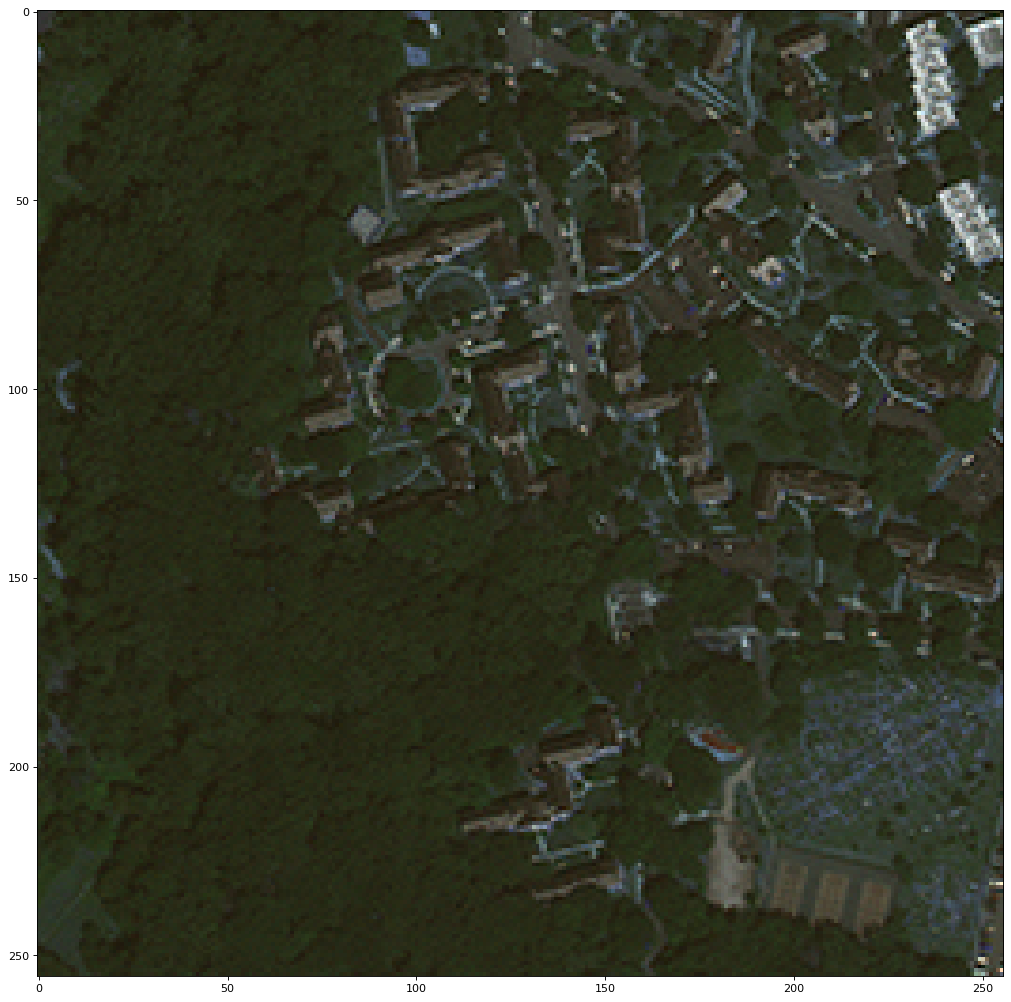

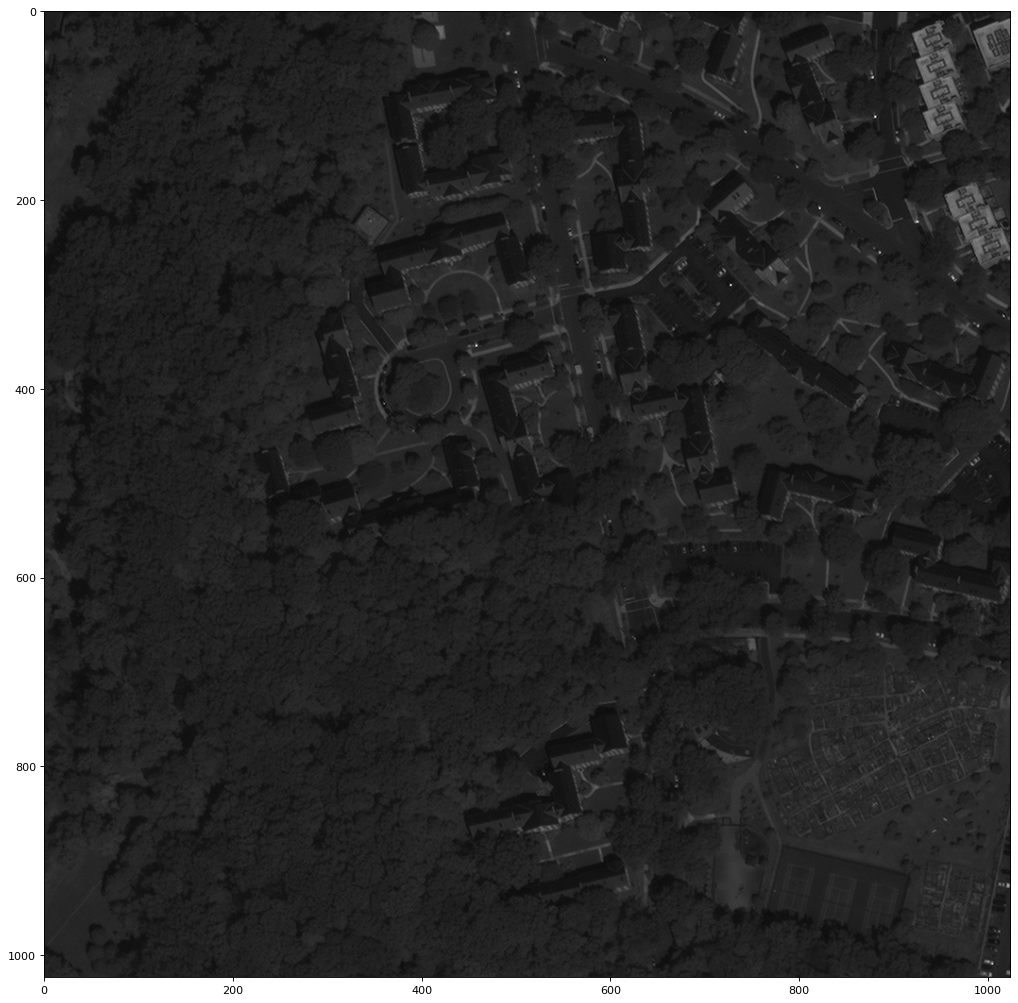

In [27]:
## Data Loading

ms_filename = '/content/PanColorGAN/data/dg_msimage200.npy'
pan_filename = '/content/PanColorGAN/data/dg_panimage200.npy'
ms = np.load(ms_filename).astype(np.float32)
pan = np.load(pan_filename).astype(np.float32)

show_image(ms)
show_image(pan)

In [28]:
## Parameters
reduced_res=False
use_gpu=True
model_weights = "/content/PanColorGANRD.pth"

In [29]:
## Data Preprocessing
from skimage.transform import resize
ms_norm = np.array([scale_range(i, -1, 1) for i in ms.transpose((2,0,1))])
pan_norm = scale_range(pan, -1, 1)

if reduced_res:
  ms_down = [resize(i,(64,64), 3) for i in ms_norm]
  ms_up = [resize(i, (256, 256), 3) for i in ms_down]
  ms_norm = np.clip(ms_up,-1.0,1.0)
  pan_down = resize(pan_norm, (256, 256), 3)
  pan_norm = np.clip(pan_down,-1.0,1.0)
else: 
  ms_up = [resize(i, (1024, 1024), 3) for i in ms_norm]
  ms_norm = np.clip(ms_up,-1.0,1.0)

inp = np.concatenate((ms_norm,np.expand_dims(pan_norm,axis=0)),axis=0)
if not reduced_res:
  inp = divide_sixteen(inp)
inp = torch.tensor(inp)

In [30]:
## Network Preparation
netG = define_G(5, 4, 32, 'batch','leakyrelu', False, 'ResizeConv', 'colorunet', 'SE', 6, [0], n_downsampling=2)
#netG.load_state_dict(torch.load(model_weights, map_location=lambda storage, loc: storage))
netG.load_state_dict(torch.load(model_weights))
netG.eval()
if use_gpu:
  netG = netG.cuda()
else:
  netG = netG.cpu()

In [31]:
if use_gpu:
  out = netG(inp.cuda().view(-1,5,256,256)).detach().cpu().numpy()
else:
  out = netG(inp.view(-1,5,256,256)).detach().numpy()

In [32]:
if not reduced_res:
  out = patch_sixteen(out)

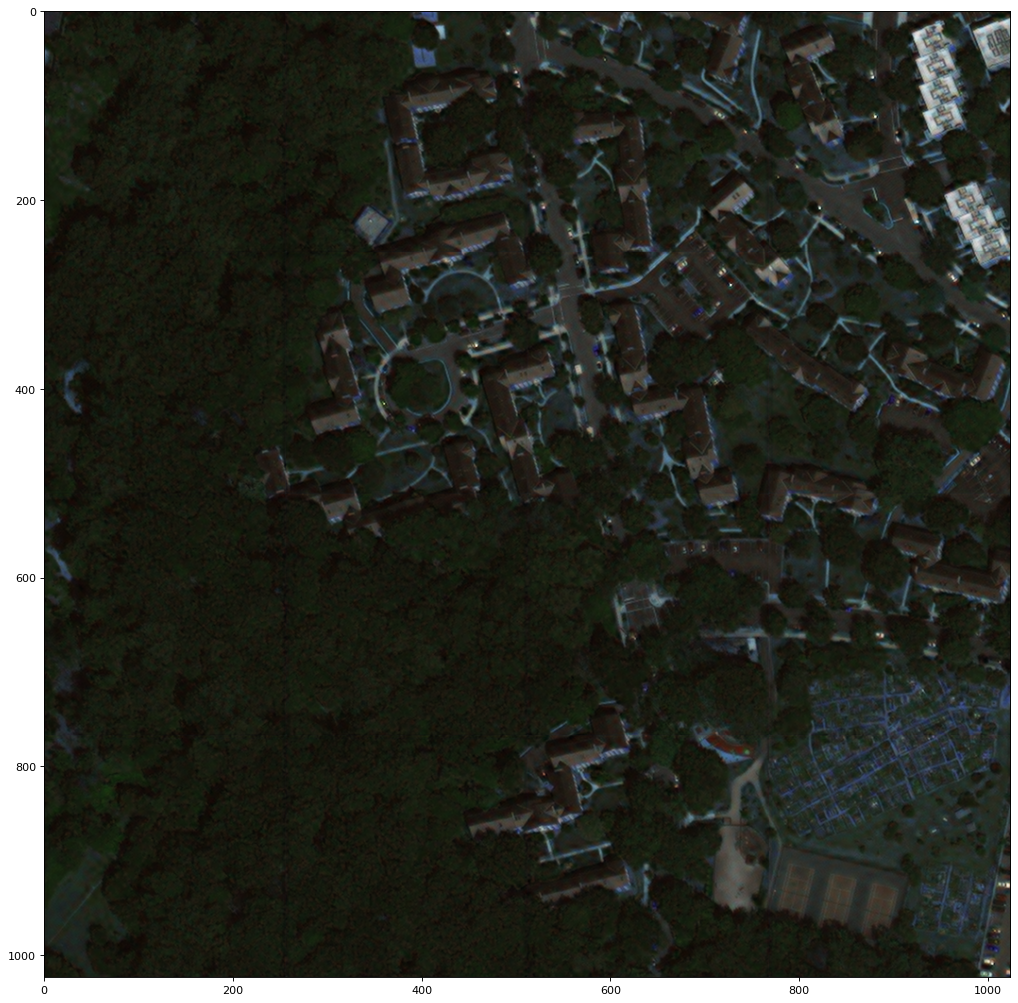

In [33]:
show_image(out.transpose(1,2,0))